In [43]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
#import swifter
from scipy import stats
%matplotlib inline

In [44]:
connection = {
'host': 'https://',
'password': '####',
'user': '####',
'database': '####'
}

In [45]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group,
    uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) >= '2022-11-25' and toDate(time) <= '2022-12-01'
group by group
"""
pandahouse.read_clickhouse(q, connection=connection)


,group,uniqExact(user_id)
0,0,8552
1,1,8496
2,2,8491
3,3,8559
4,4,8487


In [46]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-11-25' and '2022-12-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


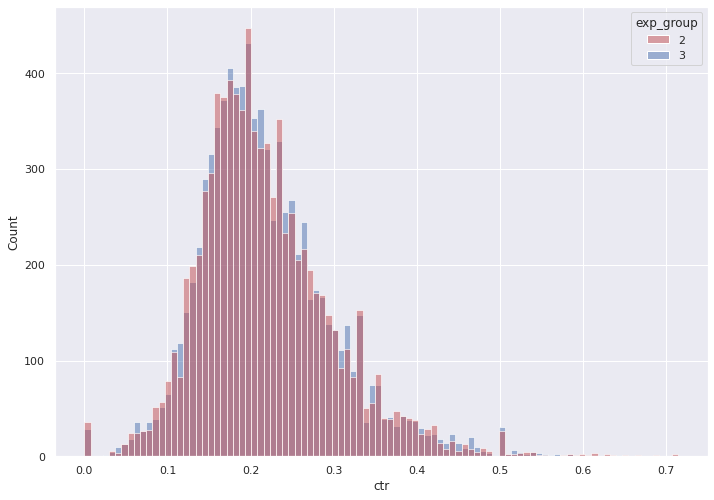

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

In [48]:
# do a t-test for users from the 2nd and 3rd experimental groups
stats.ttest_ind(df[df.exp_group == 2].ctr,
df[df.exp_group == 3].ctr,
equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [49]:
# do a t-test for subsamples of 500 users from the 2nd and 3rd experimental groups
# get p-value
tt = stats.ttest_ind(df[df.exp_group == 2].ctr.sample(n=500),
df[df.exp_group == 3].ctr.sample(n=500),
equal_var=False)
tt.pvalue

0.8254100714529924

In [50]:
# do 10,000 tests for subsamples of 500 users from the 2nd and 3rd experimental groups
#save result in array
result = []
for i in range(10000):
    tt = stats.ttest_ind(df[df.exp_group == 2].ctr.sample(n=500),
    df[df.exp_group == 3].ctr.sample(n=500),
    equal_var=False)
    result.append(tt.pvalue)
result = np.array(result)
result

array([0.82136279, 0.39555756, 0.98366396, ..., 0.28316696, 0.01804438,
       0.23520251])

Text(0.5, 1.0, 'Distribution of p-value')

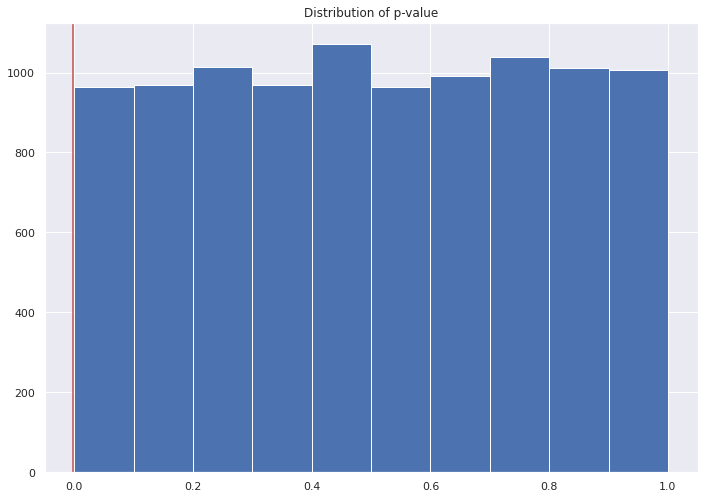

In [51]:
# create a histogram of the distribution of the results of 10,000 p-values
plt.hist(result)
plt.axvline(x=-0.001576, color='r')
plt.title('Distribution of p-value')

In [52]:
# percentage of p-values that <= 0.05
persentage_pv = (result <= 0.05).sum() / 10000 * 100
persentage_pv

4.71

H0: split system works correctly.
Made t-test 10,000 times, a subsample of 500 users from groups 2 and 3.
The result turned out to be less than 5%, which means that the split system works correctly and statistically significant differences between the 2nd and 3rd groups occur as a result of random false positives.